In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

In [2]:
dataset = pd.read_csv('india-covid-19.csv')
#parse string to datetime type
dataset['date'] = pd.to_datetime(dataset['date'], infer_datetime_format=True)
indexedDataset = dataset.set_index(['date'])

In [3]:
# indexedDataset.head(5)
indexedDataset.tail(5)

,total_cases
date,
2020-06-13,308993
2020-06-14,320922
2020-06-15,332424
2020-06-16,343091
2020-06-17,354065


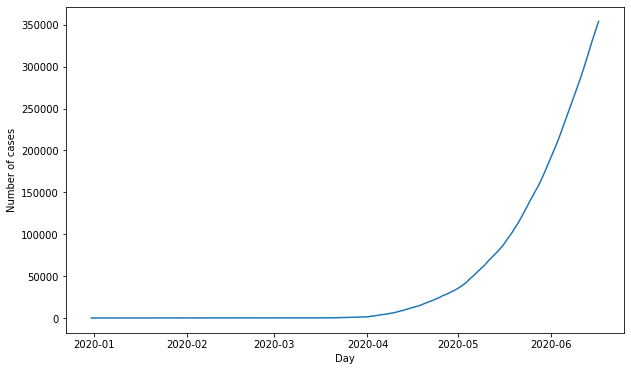

In [4]:
# plot graph
plt.xlabel('Day')
plt.ylabel("Number of cases")
plt.plot(indexedDataset)

In [5]:
# determining rolling statistics
rolmean = indexedDataset.rolling(window=7).mean()


rolstd = indexedDataset.rolling(window=7).std()

print(rolmean, rolstd)

total_cases
date                     
2019-12-31            NaN
2020-01-01            NaN
2020-01-02            NaN
2020-01-03            NaN
2020-01-04            NaN
...                   ...
2020-06-13  277075.285714
2020-06-14  287688.714286
2020-06-15  298519.142857
2020-06-16  309446.714286
2020-06-17  320515.571429

[169 rows x 1 columns]              total_cases
date                    
2019-12-31           NaN
2020-01-01           NaN
2020-01-02           NaN
2020-01-03           NaN
2020-01-04           NaN
...                  ...
2020-06-13  22299.106998
2020-06-14  23059.647733
2020-06-15  23821.622891
2020-06-16  24278.339693
2020-06-17  24460.025837

[169 rows x 1 columns]


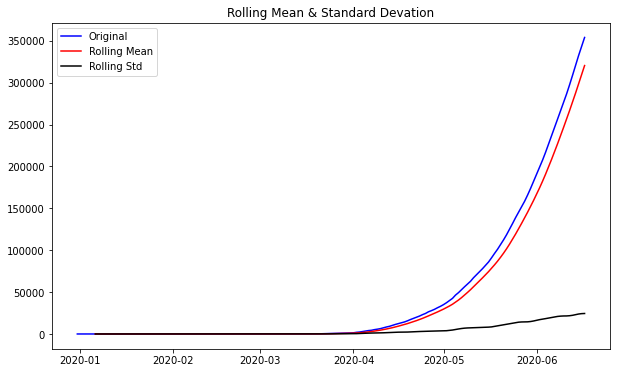

In [6]:
# Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Devation')
plt.show(block = False)

In [7]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

print('Result of Dickey-Fuller Test:')
dftest = adfuller(indexedDataset['total_cases'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value

print(dfoutput)
#Hence looking at the output we can say that the data is not stationary

Result of Dickey-Fuller Test:
Test Statistic                -7.794303e+00
p-value                        7.791559e-12
#Lags Used                     1.400000e+01
Number of Observations Used    1.540000e+02
Critical Value (1%)           -3.473543e+00
Critical Value (5%)           -2.880498e+00
Critical Value (10%)          -2.576878e+00
dtype: float64


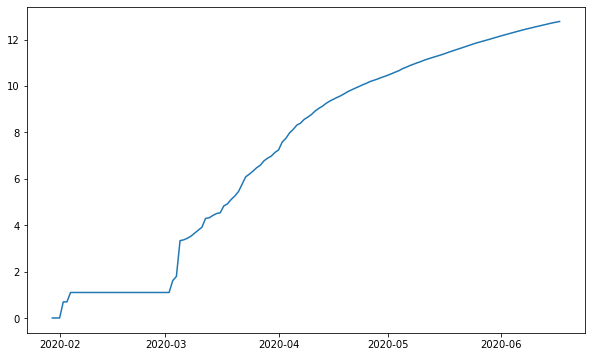

In [8]:
# Estimate the Trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

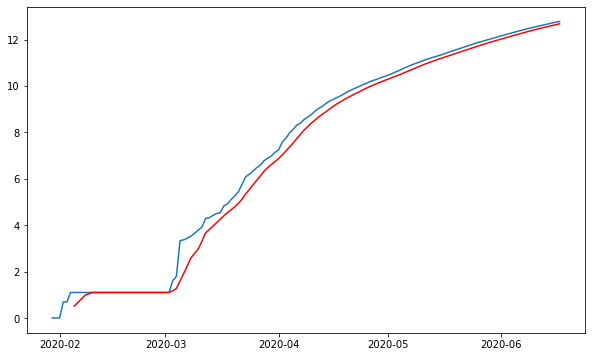

In [9]:
movingAverage = indexedDataset_logScale.rolling(window=7).mean()
movingStd = indexedDataset_logScale.rolling(window=7).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')


In [10]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(5)

#remove NaN vals
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(5)

,total_cases
date,
2020-02-05,0.586681
2020-02-06,0.429736
2020-02-07,0.272792
2020-02-08,0.115847
2020-02-09,0.057924


In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=7).mean()
    movingStd = timeseries.rolling(window=7).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Origin')        
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingStd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)


    #Perform Dickey-Fuller test:
    print('Result of Dickey-Fuller Test: ')
    dftest = adfuller(timeseries['total_cases'],autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

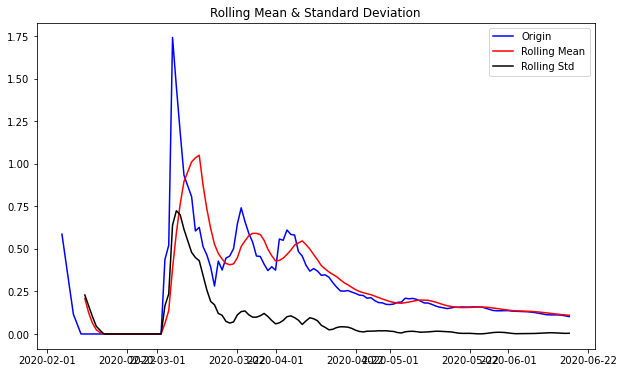

Result of Dickey-Fuller Test: 
Test Statistic                  -3.702179
p-value                          0.004083
#Lags Used                       2.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [12]:
test_stationarity(datasetLogScaleMinusMovingAverage)

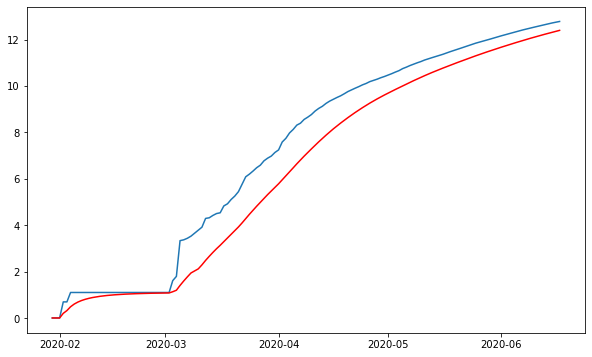

In [13]:
#weighted avg
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=7,min_periods=0, adjust=True).mean()
exponentialDecayWeightedAverage.dropna(inplace=True)
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color = 'red')

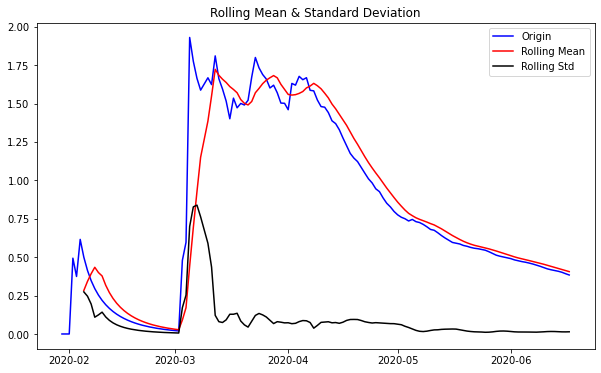

Result of Dickey-Fuller Test: 
Test Statistic                  -2.030906
p-value                          0.273188
#Lags Used                       2.000000
Number of Observations Used    136.000000
Critical Value (1%)             -3.479372
Critical Value (5%)             -2.883037
Critical Value (10%)            -2.578234
dtype: float64


In [14]:
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
datasetLogScaleMinusMovingExponentialDecayAverage.dropna(inplace=True)
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

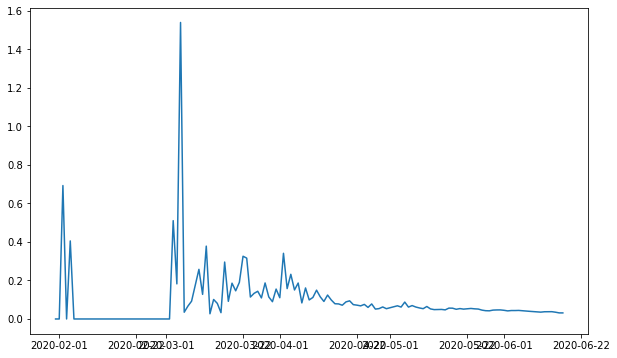

In [15]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

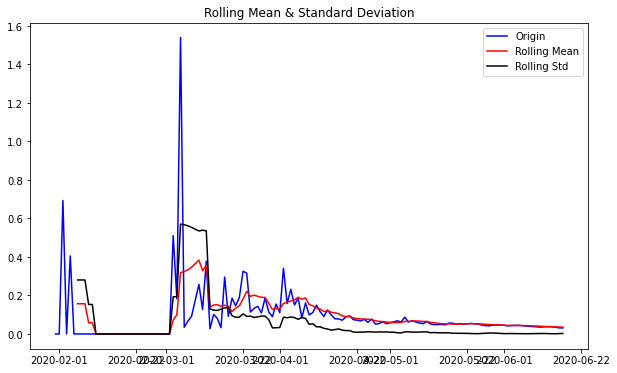

Result of Dickey-Fuller Test: 
Test Statistic                  -5.572440
p-value                          0.000001
#Lags Used                       1.000000
Number of Observations Used    136.000000
Critical Value (1%)             -3.479372
Critical Value (5%)             -2.883037
Critical Value (10%)            -2.578234
dtype: float64


In [16]:
datasetLogDiffShifting.dropna(inplace=True)
datasetLogDiffShifting.drop(datasetLogDiffShifting.index[[0]],inplace=True)
test_stationarity(datasetLogDiffShifting)
#finally we cn say that the time series is stationary

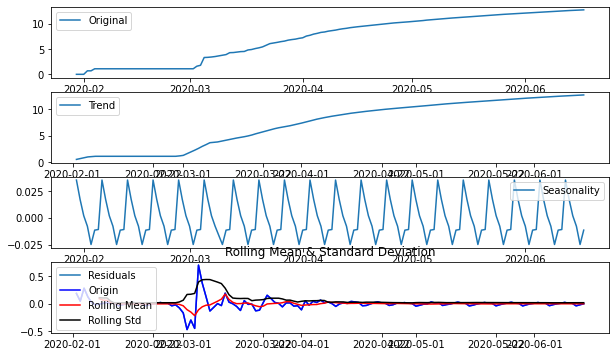

Result of Dickey-Fuller Test: 


KeyError: 'total_cases'

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
indexedDataset_logScale.replace([np.inf, -np.inf], np.nan,inplace=True)
indexedDataset_logScale.dropna(inplace=True)
decomposition = seasonal_decompose(indexedDataset_logScale,freq=7)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc="best")

plt.tight_layout

decomposedLogData = residual

# # df = pd.DataFrame({'Gene':s.index, 'count':s.values})
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

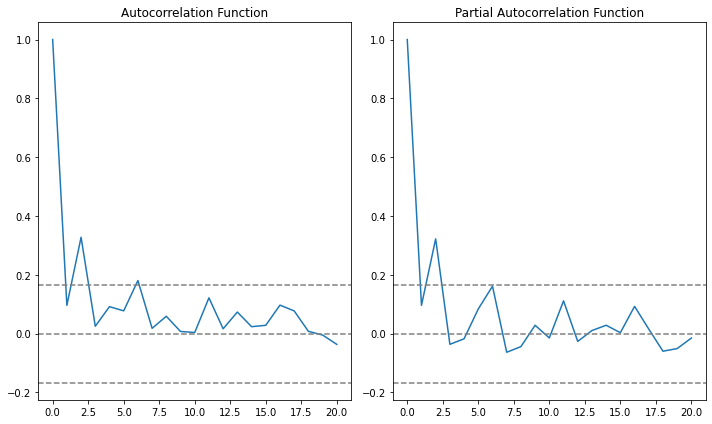

In [18]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


/home/hrithik_raj/anaconda3/envs/covid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/hrithik_raj/anaconda3/envs/covid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
Plotting AR Model


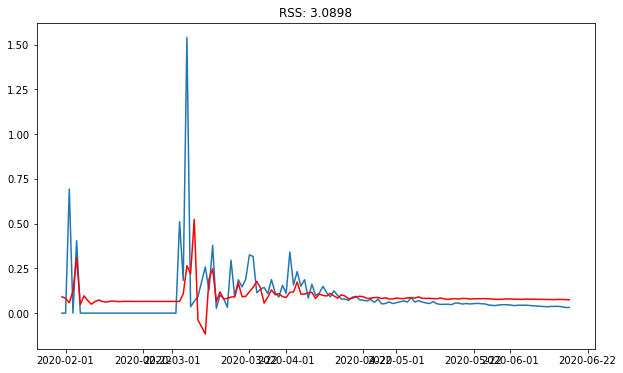

In [25]:
from statsmodels.tsa.arima_model import ARIMA

#AR Model 
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f' %sum((results_AR.fittedvalues-datasetLogDiffShifting['total_cases'])**2))
print('Plotting AR Model')



/home/hrithik_raj/anaconda3/envs/covid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/hrithik_raj/anaconda3/envs/covid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
Plotting MA Model


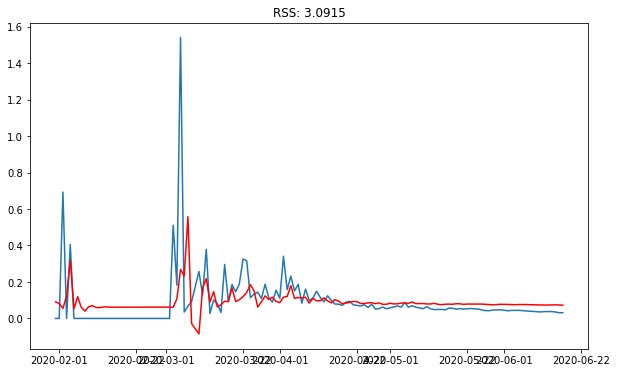

In [26]:

#MA Model 
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f' %sum((results_MA.fittedvalues-datasetLogDiffShifting['total_cases'])**2))
print('Plotting MA Model')


/home/hrithik_raj/anaconda3/envs/covid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/hrithik_raj/anaconda3/envs/covid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Text(0.5, 1.0, 'RSS: 3.0915')

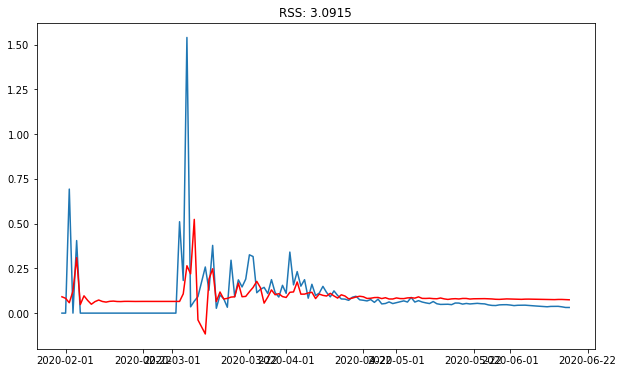

In [27]:
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f' %sum((results_MA.fittedvalues-datasetLogDiffShifting['total_cases'])**2))

In [29]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2020-01-31    0.091324
2020-02-01    0.082713
2020-02-02    0.057942
2020-02-03    0.122952
2020-02-04    0.309951
dtype: float64


In [30]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

date
2020-01-31    0.091324
2020-02-01    0.174037
2020-02-02    0.231979
2020-02-03    0.354931
2020-02-04    0.664882
dtype: float64


In [31]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['total_cases'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date
2020-01-30    0.000000
2020-01-31    0.091324
2020-02-01    0.174037
2020-02-02    0.231979
2020-02-03    0.354931
dtype: float64

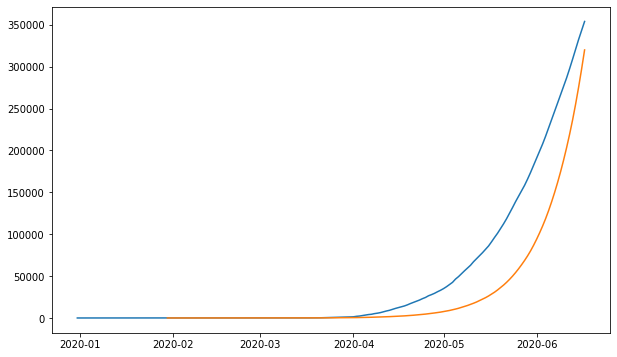

In [32]:
#Converting the data to original form
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

In [33]:
indexedDataset_logScale

,total_cases
date,
2020-01-30,0.000000
2020-01-31,0.000000
2020-02-01,0.000000
2020-02-02,0.693147
2020-02-03,0.693147
...,...
2020-06-13,12.641074
2020-06-14,12.678953
2020-06-15,12.714167


/home/hrithik_raj/anaconda3/envs/covid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hrithik_raj/anaconda3/envs/covid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hrithik_raj/anaconda3/envs/covid/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


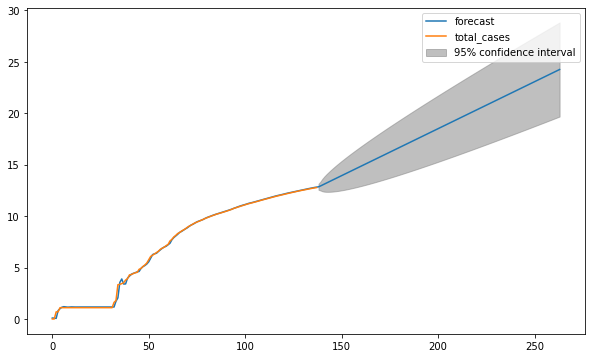

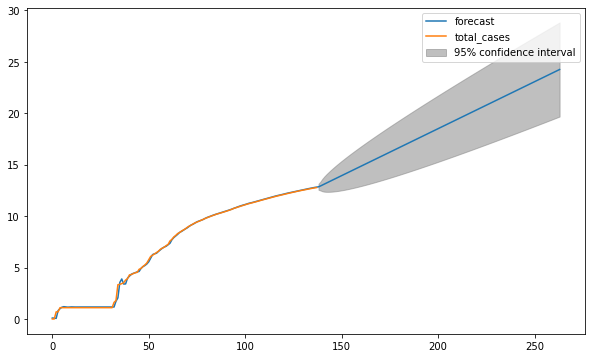

In [36]:
results_ARIMA.plot_predict(1,264)
# x=results_ARIMA.forecast(steps=120)

In [39]:
x=results_ARIMA.forecast(steps=120)
print(x)

(array([12.85086605, 12.92864542, 13.02235047, 13.1152683 , 13.2062766 ,
       13.2974143 , 13.38878032, 13.4801266 , 13.57144567, 13.66276761,
       13.75409278, 13.84541755, 13.93674193, 14.02806637, 14.11939086,
       14.21071534, 14.30203981, 14.39336428, 14.48468876, 14.57601323,
       14.66733771, 14.75866218, 14.84998666, 14.94131113, 15.03263561,
       15.12396008, 15.21528455, 15.30660903, 15.3979335 , 15.48925798,
       15.58058245, 15.67190693, 15.7632314 , 15.85455588, 15.94588035,
       16.03720483, 16.1285293 , 16.21985377, 16.31117825, 16.40250272,
       16.4938272 , 16.58515167, 16.67647615, 16.76780062, 16.8591251 ,
       16.95044957, 17.04177404, 17.13309852, 17.22442299, 17.31574747,
       17.40707194, 17.49839642, 17.58972089, 17.68104537, 17.77236984,
       17.86369431, 17.95501879, 18.04634326, 18.13766774, 18.22899221,
       18.32031669, 18.41164116, 18.50296564, 18.59429011, 18.68561458,
       18.77693906, 18.86826353, 18.95958801, 19.05091248, 19.1